In [1]:
import numpy as np
import pandas
import glob
import os
import librosa
import re
import pandas as pd
import pdb
import matplotlib.pyplot as pp
import librosa.display
from IPython import display


RAVDESS = "../data/ravdess/"
BERLIN = "../data/berlin/wav/"

AUDIO = 0
SAMPLING_RATE = 1
EMOTION = 2
ACTOR = 3
GENDER = 4
MFCC = 5

# Possible Emotions
#  - Neutral
#  - Calm
#  - Happy
#  - Sad
#  - Angry
#  - Fearful
#  - Disgust
#  - Surprised
#  - Boredom

# Possible genders
#  - male
#  - female

# 34 possible actors

class Dataset():
    def __init__(self):
        self.berlin_data = None
        self.ravdess_data = None
        self.feature_names = ["audio", "sampling_rate", "emotion", "actor", "gender"]
        
    def load(self, path):
        n = Dataset._get_num_files(path)

        if path == RAVDESS:
            self.ravdess_data = np.zeros(n, dtype=object)
        elif path == BERLIN:
            self.berlin_data = np.zeros(n, dtype=object)
        
        i = 0
        for filename in glob.iglob(path + "**", recursive=True):
            if ".wav" in filename:
                element = { "audio": None, 
                            "sampling_rate": None, 
                            "emotion": None, 
                            "actor": None, 
                            "gender": None,
                            "mfcc": None }

                audio, sampling_rate = librosa.load(filename)
                mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=12)
                emotion = Dataset._get_emotion(filename, path)
                actor = Dataset._get_actor(filename, path)
                gender = Dataset._get_gender(filename, path)
               
                element["audio"] = audio
                element["sampling_rate"] = sampling_rate
                element["emotion"] = emotion
                element["actor"] = actor
                element["gender"] = gender
                element["mfcc"] = mfcc
                if path == RAVDESS:
                    self.ravdess_data[i] = element
                elif path == BERLIN:
                    self.berlin_data[i] = element
                i += 1
     
    def save_data(self):
        np.save("./clean_data/ravdess_clean", self.ravdess_data)
        np.save("./clean_data/berlin_clean", self.berlin_data)
    
    @staticmethod
    def _get_num_files(path):
        total = 0
        for root, dirs, files in os.walk(path):
            total += len(files)
        return total

    @staticmethod
    def _get_emotion(filename, dataset_type):
        if dataset_type == RAVDESS:
            return re.findall("[0-9][0-9]", filename)[2]
        elif dataset_type == BERLIN:
            emotion = re.search("[A-Z]", filename)
            
    @staticmethod
    def _get_actor(filename, dataset_type):
        if dataset_type == RAVDESS:
            return re.findall("[0-9][0-9]", filename)[6]
        elif dataset_type == BERLIN:
            actor = re.search("[a-z][0-9][0-9]", filename)
        
    @staticmethod
    def _get_gender(filename, dataset_type):
        if dataset_type == RAVDESS:
            actor = re.findall("[0-9][0-9]", filename)[6]
            if int(actor) % 2 == 0:
                return "female"
            else:
                return "male"
        elif dataset_type == BERLIN:
            actor = re.findall("[0-9][0-9]", filename)[0]
            return Dataset._get_berlin_gender_from_actor(actor)
 
    @staticmethod
    def _get_berlin_gender_from_actor(actor):
        switch = {
                "03": "male",
                "08": "female",
                "09": "female",
                "10": "male",
                "11": "male",
                "12": "male",
                "13": "female",
                "14": "female",
                "15": "male",
                "16": "female"
        } 
        return switch.get(actor, "Invalid actor!")

In [2]:
# dataset = Dataset()
# dataset.load(RAVDESS)
# dataset.load(BERLIN)
# dataset.save_data()

def score(d1, d2):
    d1 = d1.flatten()
    d2 = d2.flatten()
    if len(d1) < len(d2): #make d1 always larger
        d2, d1 = d1, d2
    
    padded_d2 = np.zeros(d1.shape)
    padded_d2[:d2.shape[0]] = d2
    
    origdata = d1.astype('float')
    newdata = padded_d2.astype('float')

    # Compute the RMS ratio of the noise to the RMS of the original data. This is
    # not an ideal audio quality measurement - one which models human perception
    # (e.g. PEAQ) would be better - but it is simple and easy to understand.
    rms_noise = ((origdata - newdata) ** 2).mean() ** 0.5
    rms_signal = ((origdata) ** 2).mean() ** 0.5
    score = 1 - rms_noise / rms_signal
    return score

In [62]:
def demo_stft():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav') #angry
#     y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
    stft=librosa.core.stft(y)
    stft = np.abs(stft)
    print(stft.max())
    stft*=(2**64)/stft.max()
    stft=stft.astype('uint64')
    rev = librosa.core.istft(stft)
    print(score(y,rev))
    return display.Audio(rev, rate=sr)

demo_stft()

24.429287
-1.0128441723220906e+17


In [15]:
def demo_stft():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav') #angry
#     y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
    stft=librosa.core.stft(y)
    stft = np.abs(stft)
    print(stft.max())
    stft=stft.astype('uint8')
    rev = librosa.core.istft(stft)
    return display.Audio(rev, rate=sr)
    print(score(y,rev))

demo_stft()

24.429287


In [66]:
def demo_melorig():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav',sr=None) #angry
#     y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
    mel = librosa.feature.melspectrogram(y)
    rev = librosa.feature.inverse.mel_to_audio(mel)
    print(score(y,rev))
    return display.Audio(rev, rate=sr)

def demo_mel():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav',sr=None) #angry
#     y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav',sr=None) #neut
    mel = librosa.feature.melspectrogram(y)
    mel = np.abs(mel)
    print(mel.shape, mel.max())
    mel *= (255/mel.max())
    mel = mel.astype('uint8')
    rev = librosa.feature.inverse.mel_to_audio(mel.astype('float64'))
    print(score(y,rev))
    return display.Audio(rev, rate=sr)
    
demo_mel()

(128, 363) 50.947636
-1.3694945625856318


In [44]:
def demo_mfcc():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav',sr=None) #angry
    # y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
    mfcc = librosa.feature.mfcc(y)
    print(mfcc.max())
    rev = librosa.feature.inverse.mfcc_to_audio(mfcc)
    return display.Audio(rev, rate=sr)
    print(score(y,rev))
demo_mfcc()

190.89267


In [43]:
def demo_cqt():
    y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav',sr=None) #angry
    # y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
    cqt = librosa.core.cqt(y)
    print(cqt.shape)
    print(cqt.max())
    rev = librosa.core.icqt(cqt)
    print(score(y,rev))
    return display.Audio(rev, rate=sr)

demo_cqt()

(84, 363)
(0.8803051+0.25409058j)
-0.14916696029980692


/home/eric/anaconda3/lib/python3.7/site-packages/librosa/core/constantq.py:676: UserWarning: hop_length=512 exceeds minimum CQT filter length=93.853.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  'frequency resolution of your CQT.'.format(hop_length, min(lengths)))


In [8]:
# mfccs=dataset.ravdess_data[0]['mfcc']
# dataset.ravdess_data[0]['audio'].shape

# pp.plot(dataset.ravdess_data[0]['mfcc'])
# pp.plot(dataset.ravdess_data[0]['audio'])

# y, sr = librosa.load('../data/ravdess/Actor_01/03-01-03-01-01-01-01.wav') #happy

# stft1=librosa.feature.chroma_stft(y=y, sr=sr)
y, sr = librosa.load('../data/ravdess/Actor_01/03-01-05-01-01-01-01.wav') #angry
# y, sr = librosa.load('../data/ravdess/Actor_01/03-01-01-01-01-01-01.wav') #neut
print(y.shape)
stft2=librosa.core.stft(y)

rev = librosa.core.istft(stft2)

print(score(y, rev))
display.Audio(rev, rate=sr)
# print(mfccs.shape)
# print(stft.shape)

# D, wp = librosa.sequence.dtw(stft1,stft2, subseq=True)

# print(D[-1,-1])

# mfccs=librosa.feature.mfcc(y=y, sr=sr)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mfccs, x_axis='time')
# plt.colorbar()
# plt.title('MFCC')
# plt.tight_layout()
# plt.show()
# display.Audio(y, rate=sr)

(85346,)
0.9999969122942564


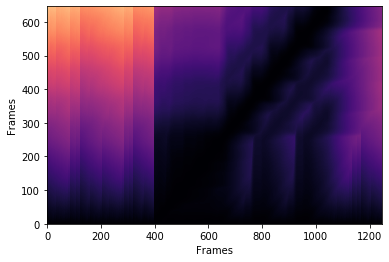

In [10]:
import numpy as np
import matplotlib.pyplot as plt
y, sr = librosa.load(librosa.util.example_audio_file(), offset=10, duration=15)
X = librosa.feature.chroma_cens(y=y, sr=sr)
noise = np.random.rand(X.shape[0], 200)
Y = np.concatenate((noise, noise, X, noise), axis=1)
D, wp = librosa.sequence.dtw(X, Y, subseq=True)
librosa.display.specshow(D, x_axis='frames', y_axis='frames')

